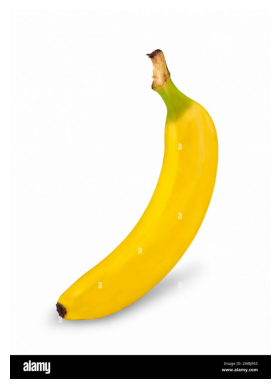

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Change filename based on what you want to see
img = cv2.imread("banana_ripe_1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()


In [ ]:
import numpy as np
from sklearn.cluster import KMeans

# read and resize the same image again
img_bgr = cv2.imread("banana_ripe_1.jpg")
img_bgr = cv2.resize(img_bgr, (256, 256))

# BGR -> HSV
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

h, w, c = img_hsv.shape
pixels = img_hsv.reshape(-1, 3)   # each row is [H, S, V]

print("Pixels array shape:", pixels.shape)


Pixels array shape: (65536, 3)


In [ ]:
k = 3  # unripe, ripe, overripe

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(pixels)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

print("Cluster centers (HSV):")
print(centers)


Cluster centers (HSV):
[[1.94298365e+00 5.47617198e-01 2.52224667e+02]
 [2.39849755e+01 2.46091680e+02 2.41771566e+02]
 [2.11131987e-01 2.06505402e+00 5.19093471e+00]]


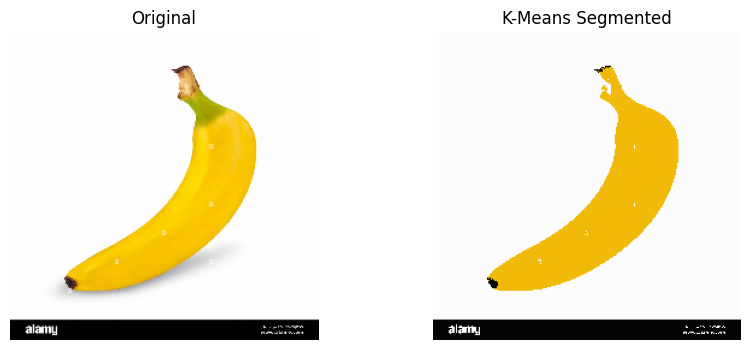

In [ ]:
# replace each pixel by its cluster center
seg_pixels = centers[labels].astype(np.uint8)
seg_hsv = seg_pixels.reshape(h, w, 3)

# HSV -> BGR -> RGB for display
seg_bgr = cv2.cvtColor(seg_hsv, cv2.COLOR_HSV2BGR)
seg_rgb = cv2.cvtColor(seg_bgr, cv2.COLOR_BGR2RGB)
orig_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(orig_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("K-Means Segmented")
plt.imshow(seg_rgb)
plt.axis("off")

plt.show()


In [ ]:
for i, c in enumerate(centers):
    print(f"Cluster {i}: H={c[0]:.1f}, S={c[1]:.1f}, V={c[2]:.1f}")


Cluster 0: H=1.9, S=0.5, V=252.2
Cluster 1: H=24.0, S=246.1, V=241.8
Cluster 2: H=0.2, S=2.1, V=5.2


In [ ]:
label_map = {
    1: "ripe",
    2: "overripe"
}

# Create mask for fruit only (ignore cluster 0)
fruit_pixels = labels != 0

fruit_labels = labels[fruit_pixels]  # only fruit

total_fruit_pixels = len(fruit_labels)

ripe_pixels = np.sum(fruit_labels == 1)
overripe_pixels = np.sum(fruit_labels == 2)

ripe_pct = (ripe_pixels / total_fruit_pixels) * 100
overripe_pct = (overripe_pixels / total_fruit_pixels) * 100

print(f"Ripe area: {ripe_pct:.2f}%")
print(f"Overripe area: {overripe_pct:.2f}%")


Ripe area: 69.68%
Overripe area: 30.32%


In [ ]:
cv2.imwrite("banana_ripe_1_segmented.jpg", seg_bgr)
print("Saved: banana_ripe_1_segmented.jpg")


Saved: banana_ripe_1_segmented.jpg


In [ ]:
# we already have: img_hsv, labels, centers, h, w from previous cells

# mapping for this banana image:
# 0 = background, 1 = ripe, 2 = overripe (from your centers)
bg_cluster = 0
ripe_cluster = 1
overripe_cluster = 2

# consider only fruit pixels (ignore background)
fruit_mask = labels != bg_cluster
fruit_labels = labels[fruit_mask]

total_fruit_pixels = len(fruit_labels)
ripe_pixels = np.sum(fruit_labels == ripe_cluster)
overripe_pixels = np.sum(fruit_labels == overripe_cluster)

ripe_pct = (ripe_pixels / total_fruit_pixels) * 100
overripe_pct = (overripe_pixels / total_fruit_pixels) * 100

print(f"Ripe area: {ripe_pct:.2f}%")
print(f"Overripe area: {overripe_pct:.2f}%")


Ripe area: 69.68%
Overripe area: 30.32%


In [ ]:
def analyze_fruit_image(filename, ripe_cluster, overripe_cluster, bg_cluster=0):
    # read & resize
    img_bgr = cv2.imread(filename)
    img_bgr = cv2.resize(img_bgr, (256, 256))

    # BGR -> HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h, w, c = img_hsv.shape
    pixels = img_hsv.reshape(-1, 3)

    # K-Means
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    kmeans.fit(pixels)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # rebuild segmented image
    seg_pixels = centers[labels].astype(np.uint8)
    seg_hsv = seg_pixels.reshape(h, w, 3)
    seg_bgr = cv2.cvtColor(seg_hsv, cv2.COLOR_HSV2BGR)

    # fruit-only mask
    fruit_mask = labels != bg_cluster
    fruit_labels = labels[fruit_mask]
    total_fruit_pixels = len(fruit_labels)

    ripe_pixels = np.sum(fruit_labels == ripe_cluster)
    overripe_pixels = np.sum(fruit_labels == overripe_cluster)

    ripe_pct = (ripe_pixels / total_fruit_pixels) * 100
    overripe_pct = (overripe_pixels / total_fruit_pixels) * 100

    return seg_bgr, ripe_pct, overripe_pct, centers


In [ ]:
image_files = [
    "banana_green_1.jpg.jpeg",
    "banana_ripe_1.jpg",
    "banana_overripe_1.jpg.jpeg"
]

results = {}

for fname in image_files:
    seg_bgr, ripe_pct, overripe_pct, centers = analyze_fruit_image(
        fname,
        ripe_cluster=1,
        overripe_cluster=2,
        bg_cluster=0
    )

    # save segmented image
    out_name = fname.replace(".jpg", "_segmented.jpg")
    cv2.imwrite(out_name, seg_bgr)

    results[fname] = (ripe_pct, overripe_pct)
    print(f"{fname} -> Ripe: {ripe_pct:.2f}%, Overripe: {overripe_pct:.2f}%")

banana_green_1.jpg.jpeg -> Ripe: 89.74%, Overripe: 10.26%
banana_ripe_1.jpg -> Ripe: 69.68%, Overripe: 30.32%
banana_overripe_1.jpg.jpeg -> Ripe: 63.47%, Overripe: 36.53%


In [ ]:
apple_files = [
    "apple_raw_1.jpg.jpeg",
    "apple_red_1.jpg.jpeg",
    "apple_ripe_1.jpg.jpeg"
]


In [ ]:
for fname in apple_files:
    seg_bgr, ripe_pct, overripe_pct, centers = analyze_fruit_image(
        fname,
        ripe_cluster=1,  # temporary guess
        overripe_cluster=2,
        bg_cluster=0
    )

    print("\nImage:", fname)
    print("Cluster centers (HSV):")
    print(centers)



Image: apple_raw_1.jpg.jpeg
Cluster centers (HSV):
[[ 43.33648369   8.27307324 217.72405363]
 [176.9467304  136.5101136   98.87621225]
 [  3.07914551 118.75030643 115.12230783]]

Image: apple_red_1.jpg.jpeg
Cluster centers (HSV):
[[ 15.66806807   3.69967467 252.69702202]
 [178.15022528 202.35362817 136.32404553]
 [ 10.29455673 184.58073036 178.58486449]]

Image: apple_ripe_1.jpg.jpeg
Cluster centers (HSV):
[[ 31.0388359   11.50180066 249.06798715]
 [ 37.3554352  207.54906422 184.12171516]
 [ 37.08386535 150.59264364 203.84452989]]


In [ ]:
apple_files = [
    "apple_raw_1.jpg.jpeg",
    "apple_red_1.jpg.jpeg",
    "apple_ripe_1.jpg.jpeg"
]

apple_results = {}

for fname in apple_files:
    seg_bgr, ripe_pct, overripe_pct, centers = analyze_fruit_image(
        fname,
        ripe_cluster=2,
        overripe_cluster=1,
        bg_cluster=0
    )

    if seg_bgr is None:
        continue  # safety

    # save segmented image
    out_name = fname.replace(".jpg.jpeg", "_segmented.jpg")
    cv2.imwrite(out_name, seg_bgr)

    apple_results[fname] = (ripe_pct, overripe_pct)
    print(f"{fname} -> Ripe: {ripe_pct:.2f}%, Overripe: {overripe_pct:.2f}%")


apple_raw_1.jpg.jpeg -> Ripe: 44.16%, Overripe: 55.84%
apple_red_1.jpg.jpeg -> Ripe: 34.05%, Overripe: 65.95%
apple_ripe_1.jpg.jpeg -> Ripe: 30.54%, Overripe: 69.46%


apple_ripe_1.jpg.jpeg -> Ripe: 30.54%, Overripe: 69.46%


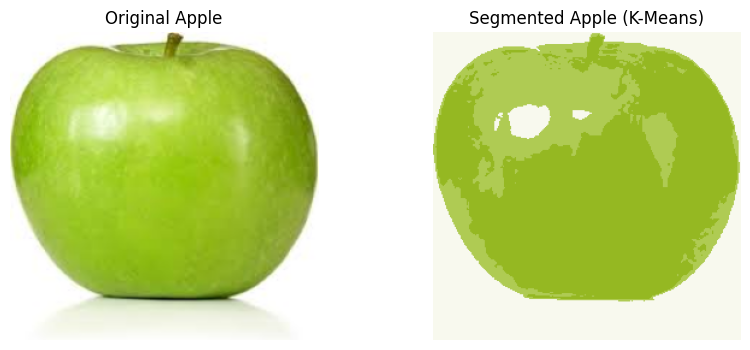

In [ ]:
import matplotlib.pyplot as plt

fname = "apple_ripe_1.jpg.jpeg"   # change to raw / red if you want

# run your pipeline
seg_bgr, ripe_pct, overripe_pct, centers = analyze_fruit_image(
    fname,
    ripe_cluster=2,      # from our mapping
    overripe_cluster=1,
    bg_cluster=0
)

print(f"{fname} -> Ripe: {ripe_pct:.2f}%, Overripe: {overripe_pct:.2f}%")

# read the original for display (same size as in function)
orig_bgr = cv2.imread(fname)
orig_bgr = cv2.resize(orig_bgr, (256, 256))

# convert both to RGB for plotting
orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
seg_rgb  = cv2.cvtColor(seg_bgr,  cv2.COLOR_BGR2RGB)

# show original vs segmented
plt.figure(figsize=(10,4))

plt.subplot(1, 2, 1)
plt.title("Original Apple")
plt.imshow(orig_rgb)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Segmented Apple (K-Means)")
plt.imshow(seg_rgb)
plt.axis("off")

plt.show()
